# Imports

In [26]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mlxtend
import torchmetrics
import random
from tqdm.auto import tqdm
import os
import glob

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# ResNet-50 model


In [28]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * Bottleneck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * Bottleneck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * Bottleneck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * Bottleneck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * Bottleneck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=1000):
        super(ResNet, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.pool1(output)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet50(num):
    return ResNet(Bottleneck, [3, 4, 6, 3], num)

In [29]:
model = resnet50(100).to(device)

# Data

In [30]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = torchvision.datasets.FGVCAircraft(
    root = './data',
    split = 'train',
    transform = transforms,
    download = True
)

test_dataset = torchvision.datasets.FGVCAircraft(
    root = './data',
    split = 'test',
    transform = transforms,
    download = True
)

train_dataloader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = 32,
    shuffle = True
)

test_dataloader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = 32,
    shuffle = False
)

In [31]:
class_names = train_dataset.classes
class_names[:5], len(class_names)

(['707-320', '727-200', '737-200', '737-300', '737-400'], 100)

# Visualize random data

In [32]:
def imshow(data, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    img_tensor, label = data
    img = img_tensor.numpy().transpose((1, 2, 0))
    img = img * std + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(str(class_names[label]))
    plt.axis(False)

In [33]:
def show_random_images(dataset, n=9):
    indices = random.sample(range(len(dataset)), n)
    data_samples = [dataset[i] for i in indices]  # Each element is a tuple (image, label)

    fig, axes = plt.subplots(3, 3, figsize=(7,7))  # 3x3 grid

    for data, ax in zip(data_samples, axes.ravel()):
        plt.sca(ax)  # Set the current axis to ax so that imshow plots on this specific axis.
        imshow(data)

    plt.tight_layout()
    plt.show()


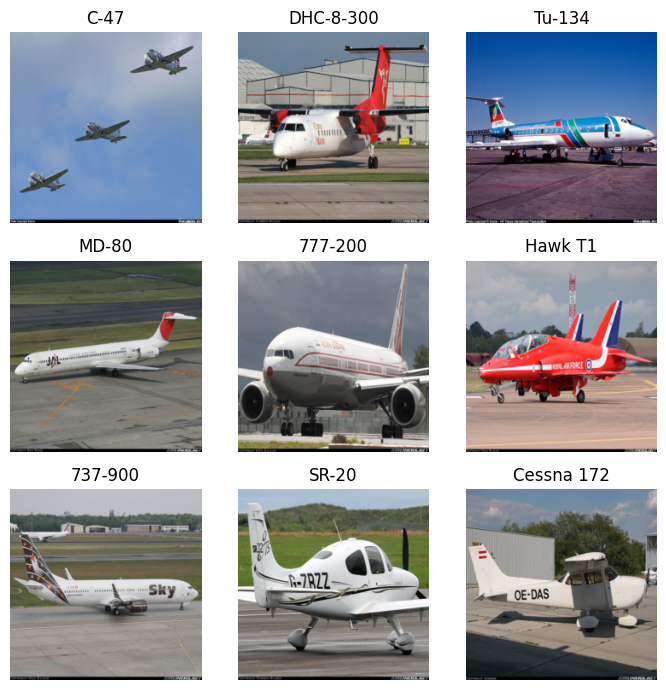

In [34]:
show_random_images(train_dataset)

# Optimizer and loss function

In [35]:
optimizer = torch.optim.SGD(
    params = model.parameters(),
    lr = 0.05
)

loss_fn = nn.CrossEntropyLoss()

accuracy_fn = torchmetrics.Accuracy(
    task = 'multiclass',
    num_classes = len(class_names)
)

# Training loop

In [36]:
def get_latest_checkpoint(directory):
    list_of_files = glob.glob(os.path.join(directory, '*.pth'))  # Adjust the pattern if needed
    if not list_of_files:
        return None
    latest_file = max(list_of_files, key=os.path.getctime)
    return latest_file

In [37]:
epochs = 30

# loading model from latest checkpoint
# Ensure checkpoint directory exists
checkpoint_directory = './checkpoints'
os.makedirs(checkpoint_directory, exist_ok=True)

# Load model from the latest checkpoint if available
latest_checkpoint_path = get_latest_checkpoint(checkpoint_directory)
if latest_checkpoint_path:
    model.load_state_dict(torch.load(latest_checkpoint_path))
    print(f"Loaded checkpoint: {latest_checkpoint_path}")
else:
    print("No checkpoint found. Starting from scratch!")


for epoch in tqdm(range(epochs)):
    ### training
    model.train()
    for X, y in tqdm(train_dataloader):
        X , y = X.to(device), y.to(device)

        train_loss = 0.0
        train_acc = 0.0

        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        acc = accuracy_fn(y_pred.argmax(dim=1), y)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += acc.item()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    accuracy_fn.reset()

    ### testing
    test_loss = 0.0
    test_acc = 0.0

    model.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            acc = accuracy_fn(y_pred.argmax(dim=1), y)

            test_loss += loss.item()
            test_acc += acc.item()

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f'Epoch: {epoch + 1} / {epochs} =>\n'
    f'Train loss: {train_loss:.4f} | Train accuracy: {train_acc}\n'
    f'Test loss: {test_loss:.4f} | Test accuracy: {test_acc}')

    # save model after each epoch
    if (epoch+1) % 10 == 0:
        checkpoint_path = f'./checkpoints/resnet50_epoch_{epoch}.pth'
        torch.save(model.state_dict(), checkpoint_path)
        print(f'Saving checkpoint to {checkpoint_path}')

Loaded checkpoint: ./checkpoints\resnet50_epoch_20.pth


  3%|▎         | 1/30 [24:19<11:45:25, 1459.50s/it]

Epoch: 1 / 30 =>
Train loss: 0.0304 | Train accuracy: 0.003174603269213722
Test loss: 12.9484 | Test accuracy: 0.022023809523809525
Saving checkpoint to ./checkpoints/resnet50_epoch_1.pth


  7%|▋         | 2/30 [52:15<12:20:26, 1586.65s/it]

Epoch: 2 / 30 =>
Train loss: 0.0288 | Train accuracy: 0.003174603269213722
Test loss: 8.6266 | Test accuracy: 0.045535714285714284


 10%|█         | 3/30 [1:20:18<12:13:57, 1631.01s/it]

Epoch: 3 / 30 =>
Train loss: 0.0243 | Train accuracy: 0.003174603269213722
Test loss: 8.0570 | Test accuracy: 0.07023809523809524


 13%|█▎        | 4/30 [1:48:33<11:57:40, 1656.17s/it]

Epoch: 4 / 30 =>
Train loss: 0.0175 | Train accuracy: 0.004761904761904762
Test loss: 10.3118 | Test accuracy: 0.04702380952380952


 17%|█▋        | 5/30 [2:16:47<11:35:43, 1669.73s/it]

Epoch: 5 / 30 =>
Train loss: 0.0142 | Train accuracy: 0.004761904761904762
Test loss: 13.7321 | Test accuracy: 0.041666666666666664


 20%|██        | 6/30 [2:44:58<11:10:45, 1676.88s/it]

Epoch: 6 / 30 =>
Train loss: 0.0321 | Train accuracy: 0.004761904761904762
Test loss: 17.1793 | Test accuracy: 0.03333333333333333


 23%|██▎       | 7/30 [3:13:11<10:44:52, 1682.30s/it]

Epoch: 7 / 30 =>
Train loss: 0.0185 | Train accuracy: 0.003174603269213722
Test loss: 10.3871 | Test accuracy: 0.033928571428571426


 27%|██▋       | 8/30 [3:41:22<10:17:48, 1684.92s/it]

Epoch: 8 / 30 =>
Train loss: 0.0076 | Train accuracy: 0.006349206538427444
Test loss: 7.4790 | Test accuracy: 0.07232142857142858


 30%|███       | 9/30 [4:09:35<9:50:41, 1687.67s/it] 

Epoch: 9 / 30 =>
Train loss: 0.0084 | Train accuracy: 0.004761904761904762
Test loss: 9.6396 | Test accuracy: 0.07202380952380952


 33%|███▎      | 10/30 [4:38:32<9:27:35, 1702.79s/it]

Epoch: 10 / 30 =>
Train loss: 0.0116 | Train accuracy: 0.004761904761904762
Test loss: 10.4837 | Test accuracy: 0.08660714285714285


 37%|███▋      | 11/30 [5:06:48<8:58:35, 1700.82s/it]

Epoch: 11 / 30 =>
Train loss: 0.0094 | Train accuracy: 0.006349206538427444
Test loss: 7.2719 | Test accuracy: 0.12690476193314507
Saving checkpoint to ./checkpoints/resnet50_epoch_11.pth


 40%|████      | 12/30 [5:35:02<8:29:33, 1698.55s/it]

Epoch: 12 / 30 =>
Train loss: 0.0089 | Train accuracy: 0.007936507747286842
Test loss: 19.0731 | Test accuracy: 0.033928571428571426


 43%|████▎     | 13/30 [6:03:12<8:00:32, 1696.05s/it]

Epoch: 13 / 30 =>
Train loss: 0.0004 | Train accuracy: 0.009523809523809525
Test loss: 3.8983 | Test accuracy: 0.3107142857142857


 47%|████▋     | 14/30 [6:31:19<7:31:31, 1693.25s/it]

Epoch: 14 / 30 =>
Train loss: 0.0155 | Train accuracy: 0.004761904761904762
Test loss: 12.5559 | Test accuracy: 0.04255952380952381


 50%|█████     | 15/30 [6:59:26<7:02:50, 1691.36s/it]

Epoch: 15 / 30 =>
Train loss: 0.0049 | Train accuracy: 0.007936507747286842
Test loss: 12.6686 | Test accuracy: 0.07083333333333333


 53%|█████▎    | 16/30 [7:27:29<6:34:05, 1688.96s/it]

Epoch: 16 / 30 =>
Train loss: 0.0026 | Train accuracy: 0.007936507747286842
Test loss: 7.2974 | Test accuracy: 0.1595238095238095


 57%|█████▋    | 17/30 [7:55:33<6:05:35, 1687.37s/it]

Epoch: 17 / 30 =>
Train loss: 0.0064 | Train accuracy: 0.006349206538427444
Test loss: 19.0732 | Test accuracy: 0.05029761904761905


 60%|██████    | 18/30 [8:23:36<5:37:12, 1686.07s/it]

Epoch: 18 / 30 =>
Train loss: 0.0013 | Train accuracy: 0.009523809523809525
Test loss: 5.2691 | Test accuracy: 0.2658928571712403


 63%|██████▎   | 19/30 [8:47:54<4:56:33, 1617.64s/it]

Epoch: 19 / 30 =>
Train loss: 0.0015 | Train accuracy: 0.009523809523809525
Test loss: 5.1525 | Test accuracy: 0.2551785714569546


 67%|██████▋   | 20/30 [9:13:49<4:26:28, 1598.85s/it]

Epoch: 20 / 30 =>
Train loss: 0.0044 | Train accuracy: 0.007936507747286842
Test loss: 9.3062 | Test accuracy: 0.12142857142857143


 70%|███████   | 21/30 [9:39:43<3:57:47, 1585.28s/it]

Epoch: 21 / 30 =>
Train loss: 0.0004 | Train accuracy: 0.009523809523809525
Test loss: 4.1766 | Test accuracy: 0.3161904762188594
Saving checkpoint to ./checkpoints/resnet50_epoch_21.pth


 73%|███████▎  | 22/30 [10:06:11<3:31:28, 1586.03s/it]

Epoch: 22 / 30 =>
Train loss: 0.0046 | Train accuracy: 0.006349206538427444
Test loss: 10.6808 | Test accuracy: 0.11220238095238096


 77%|███████▋  | 23/30 [10:32:13<3:04:12, 1578.93s/it]

Epoch: 23 / 30 =>
Train loss: 0.0075 | Train accuracy: 0.006349206538427444
Test loss: 19.6973 | Test accuracy: 0.04327380955219269


 80%|████████  | 24/30 [10:57:59<2:36:53, 1568.96s/it]

Epoch: 24 / 30 =>
Train loss: 0.0005 | Train accuracy: 0.009523809523809525
Test loss: 4.1883 | Test accuracy: 0.31398809523809523


 83%|████████▎ | 25/30 [11:23:55<2:10:25, 1565.16s/it]

Epoch: 25 / 30 =>
Train loss: 0.0115 | Train accuracy: 0.004761904761904762
Test loss: 21.1827 | Test accuracy: 0.025


 87%|████████▋ | 26/30 [11:47:42<1:41:34, 1523.66s/it]

Epoch: 26 / 30 =>
Train loss: 0.0012 | Train accuracy: 0.009523809523809525
Test loss: 4.3828 | Test accuracy: 0.30589285719962345


 90%|█████████ | 27/30 [12:13:34<1:16:36, 1532.22s/it]

Epoch: 27 / 30 =>
Train loss: 0.0011 | Train accuracy: 0.009523809523809525
Test loss: 4.5314 | Test accuracy: 0.30083333339009966


 93%|█████████▎| 28/30 [12:36:50<49:42, 1491.46s/it]  

Epoch: 28 / 30 =>
Train loss: 0.0009 | Train accuracy: 0.009523809523809525
Test loss: 4.6022 | Test accuracy: 0.2755357143424806


 97%|█████████▋| 29/30 [13:02:04<24:58, 1498.13s/it]

Epoch: 29 / 30 =>
Train loss: 0.0004 | Train accuracy: 0.009523809523809525
Test loss: 4.1584 | Test accuracy: 0.33208333339009966


100%|██████████| 30/30 [13:26:21<00:00, 1612.72s/it]

Epoch: 30 / 30 =>
Train loss: 0.0052 | Train accuracy: 0.007936507747286842
Test loss: 12.8960 | Test accuracy: 0.05625
